<a href="https://colab.research.google.com/github/zhuyuan7/nlp_test/blob/main/2021-04-08-kobert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers==3 # 최신 버전으로 설치하면 "Input: must be Tensor, not str" 라는 에러 발생
!pip install torch

!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

     |████████████████████████████████| 46.9MB 66kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
     |████████████████████████████████| 348kB 5.1MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp37-cp37m-linux_x86_64.whl size=595684 sha256=bb91ed7c018c27ff18f731d27b021bc0079b02453dc2d61d9eec520605810512
  Stored in directory: /root/.cache/pip/wheels/37/65/52/63032864a0f31a08b9a88569f803b5bafac8abd207fd7f7534
Successfully built gluonnlp
     |████████████████████████████████| 1.2MB 5.1MB/s 
     |████████████████████████████████| 757kB 6.5MB/s 
     |████████████████████████████████| 870kB 10.7MB/s 
     |████████████████████████████████| 3.0MB 12.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=668377baf07c0e4bec014071860d8cabbb213c2d70172b743a1e2c15587686df
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f44836

In [4]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook

from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model

from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

In [5]:
##GPU 사용 시
device = torch.device("cuda:0")


In [6]:
bertmodel, vocab = get_pytorch_kobert_model()

[██████████████████████████████████████████████████]
[██████████████████████████████████████████████████]


In [7]:
# 학습용 데이터셋 불러오기
import pandas as pd

td_hate = pd.read_csv('/content/drive/MyDrive/케글/train.hate.csv')
td_hate.head
td_hate



,comments,label
0,(현재 호텔주인 심정) 아18 난 마른하늘에 날벼락맞고 호텔망하게생겼는데 누군 계속...,hate
1,....한국적인 미인의 대표적인 분...너무나 곱고아름다운모습...그모습뒤의 슬픔을...,none
2,"...못된 넘들...남의 고통을 즐겼던 넘들..이젠 마땅한 처벌을 받아야지..,그래...",hate
3,"1,2화 어설펐는데 3,4화 지나서부터는 갈수록 너무 재밌던데",none
4,1. 사람 얼굴 손톱으로 긁은것은 인격살해이고2. 동영상이 몰카냐? 메걸리안들 생각...,hate
...,...,...
7891,힘내세요~ 응원합니다!!,none
7892,힘내세요~~삼가 고인의 명복을 빕니다..,none
7893,힘내세용 ^^ 항상 응원합니닷 ^^ !,none
7894,힘내소...연기로 답해요.나도 53살 인데 이런일 저런일 다 있더라구요.인격을 믿습...,none


In [69]:
dev_hate = pd.read_csv('/content/drive/MyDrive/케글/dev.hate.csv')
dev_hate.head
dev_hate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 471 entries, 0 to 470
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   comments  471 non-null    object
 1   label     471 non-null    object
dtypes: object(2)
memory usage: 7.5+ KB


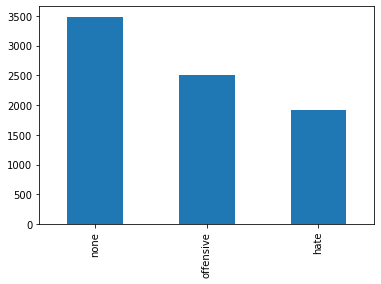

In [11]:
td_hate['label'].value_counts().plot(kind='bar')

In [12]:
print(td_hate.groupby('label').size().reset_index(name='count'))

       label  count
0       hate   1911
1       none   3486
2  offensive   2499


In [13]:
td_hate['comments']= td_hate['comments'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
td_hate['comments'] = td_hate['comments'].str.replace('^ +', "")
td_hate['comments'].replace('', np.nan, inplace=True)
print(td_hate.isnull().sum())


comments    0
label       0
dtype: int64


In [14]:
dev_hate['comments']= dev_hate['comments'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
dev_hate['comments'] = dev_hate['comments'].str.replace('^ +', "")
dev_hate['comments'].replace('', np.nan, inplace=True)
print(dev_hate.isnull().sum())

comments    0
label       0
dtype: int64


In [15]:
dev_hate.info()
print('')
print('----')
td_hate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 471 entries, 0 to 470
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   comments  471 non-null    object
 1   label     471 non-null    object
dtypes: object(2)
memory usage: 7.5+ KB

----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7896 entries, 0 to 7895
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   comments  7896 non-null   object
 1   label     7896 non-null   object
dtypes: object(2)
memory usage: 123.5+ KB


In [30]:
# 욕 강도 추출
data1 = td_hate.loc[td_hate['label'] == 'none']
data2 = td_hate.loc[td_hate['label'] == 'offensive']
data3 = td_hate.loc[td_hate['label'] == 'hate']

new_td_hate = data1.append([data2,data3],sort=False)
new_td_hate = pd.DataFrame(new_td_hate)
new_td_hate.head()

new_dev_hate = data1.append([data2,data3],sort=False)
new_dev_hate = pd.DataFrame(new_dev_hate)
new_dev_hate.head()



,comments,label
1,한국적인 미인의 대표적인 분너무나 곱고아름다운모습그모습뒤의 슬픔을 미처 알지못했네요ㅠ,none
3,화 어설펐는데 화 지나서부터는 갈수록 너무 재밌던데,none
5,진짜 이승기랑 비교된다,none
7,년뒤 윤서인은 분명히 재평가될것임 말하나하나가 틀린게없음,none
10,살 차이가 넘을텐데 부부라고 무슨 내용인지 긍금하네,none


In [72]:
# td_hate 욕 강도 라벨링

from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(new_td_hate['label'])
new_td_hate['label'] = encoder.fit_transform(new_td_hate['label'])
new_td_hate.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 7896 entries, 1 to 7887
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   comments  7896 non-null   object
 1   label     7896 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 185.1+ KB


In [68]:
# dev_hate 욕 강도 추출
data1 = dev_hate.loc[td_hate['label'] == 'none']
data2 = dev_hate.loc[td_hate['label'] == 'offensive']
data3 = dev_hate.loc[td_hate['label'] == 'hate']

new_dev_hate = data1.append([data2,data3],sort=False)
new_dev_hate = pd.DataFrame(new_dev_hate)
new_dev_hate.head()

,comments,label
1,지현우 나쁜놈,offensive
3,설마 ㅈ 현정 작가 아니지,hate
5,일베충들 ㅂㄷ거리는것봐라 ㅉㅉ,hate
7,강부자 선생님 전미선 비보에 오열을 하셨다니 눈물이 나네요 힘내세요,none
10,이경규가 이런거보면 세련되긴함 저 나이에 차은우 누가 알꼬 아무리 잘생겼다해도 배워...,none


In [66]:
encoder = LabelEncoder()
encoder.fit(new_dev_hate['label'])
new_dev_hate['label'] = encoder.transform(new_dev_hate['label'])
new_dev_hate.head()
new_dev_hate.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 471 entries, 1 to 470
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   comments  471 non-null    object
 1   label     471 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 11.0+ KB


In [33]:
# 라벨링 된 욕 강도 매핑  --> {0: 'hate', 1: 'none', 2: 'offensive'}

mapping = dict(zip(range(len(encoder.classes_)), encoder.classes_))
mapping

{0: 'hate', 1: 'none', 2: 'offensive'}

In [34]:
# 기본 Bert tokenizer 사용
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

using cached model


In [ ]:
 #에러 
 '''
 class BERTDataset(Dataset): 에러      
        # self.labels = [np.int32(i[label_idx]) for i in dataset] 로 하니까 
        
        data_train = BERTDataset(td_hate, 0, 1, tok, max_len, True, False) 에러1발생
        # 에러1:  ValueError: invalid literal for int() with base 10: 'o'

        # 그래서 np.int32(i[label_idx]) --> np.str(i[label_idx]) 스트링 형태로 형변환
        # self.labels = [np.str(i[label_idx]) for i in dataset]
'''

In [73]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        
        # 에러 ValueError: invalid literal for int() with base 10: 'o'
        # np.int32(i[label_idx]) --> np.str(i[label_idx])
        self.labels = [np.str(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))



In [74]:
# Setting parameters
max_len = 64 # 해당 길이를 초과하는 단어에 대해선 bert가 학습하지 않음
batch_size = 64
warmup_ratio = 0.1
num_epochs = 5
max_grad_norm = 1
log_interval = 200
learning_rate = 5e-5

In [75]:
# self.labels = [np.int32(i[label_idx]) for i in dataset
#에러 :ValueError: invalid literal for int() with base 10: 'o'
data_train = BERTDataset(td_hate, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(dev_hate, 0, 1, tok, max_len, True, False)

# pytorch용 DataLoader 사용
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
dev_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [76]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes = 3, # softmax 사용 <- binary일 경우는 2
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [77]:
model = BERTClassifier(bertmodel, dr_rate=0.5).to(device)

In [78]:
# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]


In [79]:
# 옵티마이저 선언
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss() # softmax용 Loss Function 정하기 <- binary classification도 해당 loss function 사용 가능

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

In [80]:
# 학습 평가 지표인 accuracy 계산 -> 얼마나 타겟값을 많이 맞추었는가
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [ ]:
# 에러2 :   #AttributeError: 'tuple' object has no attribute 'long'
#        label = label.long().to(device)


In [83]:
# 모델 학습 시작
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length

        #AttributeError: 'tuple' object has no attribute 'long'
        label = label.long().to(device)
        
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm) # gradient clipping
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


AttributeError: ignored